In [1]:
# Cell 1: Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style='whitegrid')


In [2]:
# Cell 2: Load & Inspect Data
df = pd.read_csv('D:\infosysspringboard projects\project1-1stmilestine\AZURE_BACKEND_TEAM-B\data\processed\cleaned_merged.csv', parse_dates=['date'])
print(df.shape, df.columns.tolist())
df.head()


(1080, 9) ['date', 'region', 'resource_type', 'usage_cpu', 'usage_storage', 'users_active', 'economic_index', 'cloud_market_demand', 'holiday']


,date,region,resource_type,usage_cpu,usage_storage,users_active,economic_index,cloud_market_demand,holiday
0,2023-01-01,East US,VM,88,1959,470,104.97,0.99,1
1,2023-01-01,East US,Storage,92,1595,388,104.97,0.99,1
2,2023-01-01,East US,Container,70,621,414,104.97,0.99,1
3,2023-01-01,West US,VM,60,1982,287,104.97,0.99,1
4,2023-01-01,West US,Storage,85,1371,351,104.97,0.99,1


In [3]:
# Cell 3: Aggregate by Region & Date
region_daily = (
    df
    .groupby(['region','date'])
    .agg(usage_cpu=('usage_cpu','mean'),
         usage_storage=('usage_storage','mean'),
         users_active=('users_active','sum'),
         economic_index=('economic_index','first'),
         cloud_market_demand=('cloud_market_demand','first'),
         holiday=('holiday','max'))
    .sort_index()
    .reset_index()
)
print(region_daily.shape)
region_daily.head()


(360, 8)


,region,date,usage_cpu,usage_storage,users_active,economic_index,cloud_market_demand,holiday
0,East US,2023-01-01,83.333333,1391.666667,1272,104.97,0.99,1
1,East US,2023-01-02,91.666667,1456.666667,800,106.48,1.15,0
2,East US,2023-01-03,78.333333,1138.333333,1285,97.66,0.98,0
3,East US,2023-01-04,75.000000,881.000000,872,115.79,1.08,0
4,East US,2023-01-05,86.666667,1234.000000,1017,95.31,1.05,0


In [4]:
# Modified Cell 4: Create Global Time Series aggregating over regions and resource types

# First convert date column to datetime if not already
region_daily['date'] = pd.to_datetime(region_daily['date'])

# Aggregate across all regions and resource types by date (global aggregation)
agg_funcs = {
    'usage_cpu': 'mean',
    'usage_storage': 'mean',
    'users_active': 'mean',
    'economic_index': 'mean',
    'cloud_market_demand': 'mean',
    'holiday': lambda x: 1 if x.mode().iloc[0] == 1 else 0  # majority value for holiday (mode)
}

global_ts = region_daily.groupby('date').agg(agg_funcs).asfreq('D')

print("Global TS shape:", global_ts.shape)
print(global_ts.head())


Global TS shape: (90, 6)
            usage_cpu  usage_storage  users_active  economic_index  \
date                                                                 
2023-01-01  74.916667    1509.000000       1161.00          104.97   
2023-01-02  75.166667    1286.833333        955.00          106.48   
2023-01-03  76.500000    1147.750000       1120.75           97.66   
2023-01-04  72.083333    1126.916667        981.50          115.79   
2023-01-05  76.500000    1580.500000       1110.25           95.31   

            cloud_market_demand  holiday  
date                                      
2023-01-01                 0.99        1  
2023-01-02                 1.15        0  
2023-01-03                 0.98        0  
2023-01-04                 1.08        0  
2023-01-05                 1.05        0  


In [5]:
# Modified Cell 5: Train/Test Split Function for Global Time Series
def train_test_split_global_ts(ts, train_frac=0.8):
    """
    Splits a global time series (indexed by date) into train and test sets.
    
    Parameters:
    ts : pd.Series or pd.DataFrame
        The global time series data indexed by date.
    train_frac : float
        Fraction of data to use for training.
        
    Returns:
    train_ts, test_ts : tuple of same type as ts
        Train and test splits.
    """
    n = len(ts)
    split = int(train_frac * n)
    train_ts = ts.iloc[:split]
    test_ts = ts.iloc[split:]
    return train_ts, test_ts

# Usage example:
# train_global, test_global = train_test_split_global_ts(global_ts)


In [6]:
# Cell 6 (updated): ARIMA for Global Time Series

from statsmodels.tsa.arima.model import ARIMA

arima_results_global = {}

def compute_metrics(true_vals, preds):
    rmse = np.sqrt(mean_squared_error(true_vals, preds))
    mae = mean_absolute_error(true_vals, preds)
    mape = np.mean(np.abs((true_vals - preds) / true_vals)) * 100
    return rmse, mae, mape

# Use global_ts from aggregated global timeseries with index=date and columns including 'usage_cpu'
split = int(0.8 * len(global_ts))

# Optionally, apply differencing if trend removal is needed — example like East US code above
ts = global_ts['usage_cpu']

# Applying first differencing
ts_diff = ts.diff().dropna()
train_ts = ts_diff.iloc[: split - 1]
test_ts = ts_diff.iloc[split - 1 :]

# Fit ARIMA on differenced series
model = ARIMA(train_ts, order=(5, 0, 0)).fit()
preds_diff = model.forecast(steps=len(test_ts))

# Reconstruct original series forecast
last_train = ts.iloc[split - 1]
arima_preds = np.r_[ [last_train], preds_diff ].cumsum()[1:]
actual = ts.iloc[split:]

# Compute metrics
arima_rmse, arima_mae, arima_mape = compute_metrics(actual, arima_preds)
arima_results_global['Global'] = (model, arima_rmse, arima_mae, arima_mape)

print(f"Global ARIMA → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.1f}%")


Global ARIMA → RMSE: 4.63, MAE: 4.23, MAPE: 5.8%


In [7]:
# Cell 7 (updated): XGBoost with Rich Features on Global Time Series

xgb_results_global = {}

df2 = global_ts.copy()  # Use the globally aggregated time series

# rolling stats + time features
df2['lag1']       = df2['usage_cpu'].shift(1)
df2['lag7']       = df2['usage_cpu'].shift(7)
df2['roll7_mean'] = df2['usage_cpu'].rolling(7).mean()
df2['dow']        = df2.index.dayofweek

df2.dropna(inplace=True)

features = ['lag1', 'lag7', 'roll7_mean', 'users_active', 'economic_index', 'dow', 'holiday']
X, y = df2[features], df2['usage_cpu']

split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=800,
    early_stopping_rounds=10
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae  = mean_absolute_error(y_test, preds)

xgb_results_global['Global'] = (model, rmse, mae, X_test.index, y_test, preds)

print(f"Global XGB – RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Global XGB – RMSE: 4.23, MAE: 3.66


In [8]:
# Cell 8 (updated): Univariate LSTM for Global Time Series

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

lstm_results_global = {}
n_steps = 30

# Use global_ts from aggregated global time series with index=date
seq = global_ts[['usage_cpu']].values

# Scale the data
scaler = MinMaxScaler()
seq_scaled = scaler.fit_transform(seq)

# Create sequences and targets
Xs, ys = [], []
for i in range(n_steps, len(seq_scaled)):
    Xs.append(seq_scaled[i-n_steps:i, 0])
    ys.append(seq_scaled[i, 0])
Xs, ys = np.array(Xs), np.array(ys)

# Train/test split
split_l = int(0.8 * len(Xs))
X_train_l, X_test_l = Xs[:split_l], Xs[split_l:]
y_train_l, y_test_l = ys[:split_l], ys[split_l:]

# Reshape for LSTM input (samples, timesteps, features)
X_train_l = X_train_l.reshape((len(X_train_l), n_steps, 1))
X_test_l  = X_test_l.reshape((len(X_test_l),  n_steps, 1))

# Define LSTM model
lstm_model = Sequential([
    LSTM(50, input_shape=(n_steps, 1)),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping callback
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
lstm_model.fit(
    X_train_l, y_train_l,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[es],
    verbose=0
)

# Predict and inverse scale
preds_scaled = lstm_model.predict(X_test_l, verbose=0).flatten()
y_test_inv = scaler.inverse_transform(y_test_l.reshape(-1,1)).flatten()
preds_inv  = scaler.inverse_transform(preds_scaled.reshape(-1,1)).flatten()

# Compute metrics
lstm_rmse, lstm_mae, lstm_mape = compute_metrics(y_test_inv, preds_inv)

lstm_results_global['Global'] = (lstm_model, scaler, lstm_rmse, lstm_mae, X_test_l, y_test_inv, preds_inv)

print(f"Global LSTM → RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.1f}%")


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Global LSTM → RMSE: 5.14, MAE: 4.83, MAPE: 6.6%


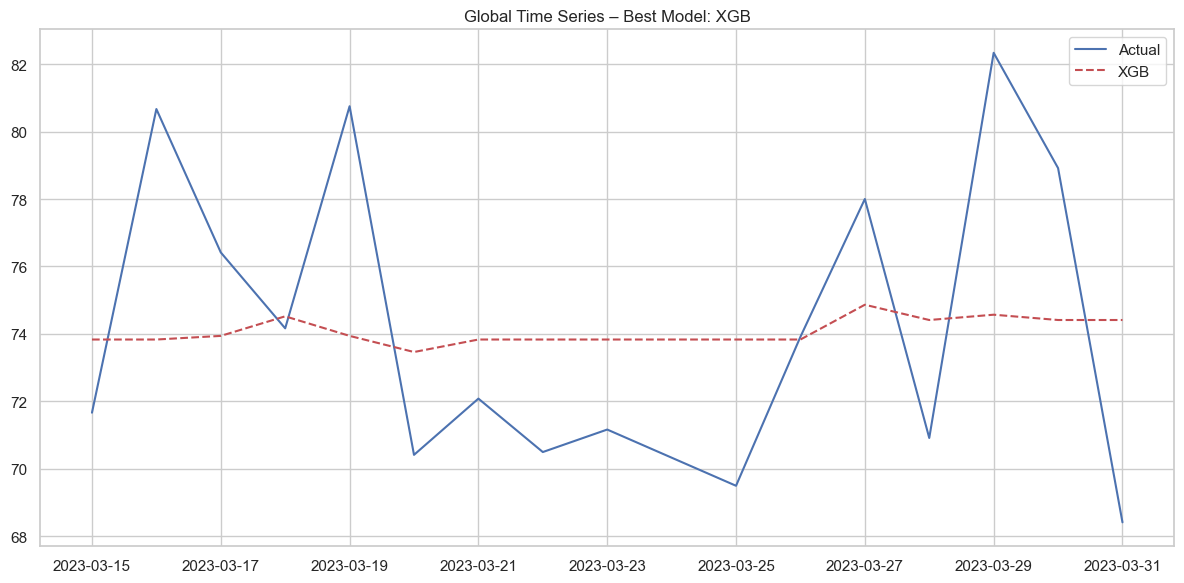


=== GLOBAL SUMMARY TABLE ===
        ARIMA_RMSE  ARIMA_MAE  ARIMA_MAPE  XGB_RMSE  XGB_MAE  LSTM_RMSE  \
region                                                                    
Global        4.63       4.23        5.79      4.23     3.66       5.14   

        LSTM_MAE  
region            
Global      4.83  


In [14]:
# Cell 9 (updated): Compare & Visualize with Summary Table of Metrics for Global Time Series

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare summary results list
results_global = []

fig, ax = plt.subplots(figsize=(12, 6))

# Extract metrics for Global models
arima_model, arima_rmse, arima_mae, arima_mape = arima_results_global['Global']
xgb_model, xgb_rmse, xgb_mae, xgb_idx, xgb_y_test, xgb_preds = xgb_results_global['Global']
lstm_model, lstm_scaler, lstm_rmse, lstm_mae, lstm_X_test, lstm_y_test, lstm_preds = lstm_results_global['Global']

# Identify best model by RMSE
metrics_global = {
    'ARIMA': arima_rmse,
    'XGB': xgb_rmse,
    'LSTM': lstm_rmse
}
best_model = min(metrics_global, key=metrics_global.get)

# Plot actual and predictions for best model
if best_model == 'ARIMA':
    split = int(0.8 * len(global_ts))
    test = global_ts['usage_cpu'].iloc[split:]
    ts = global_ts['usage_cpu']
    ts_diff = ts.diff().dropna()
    train_ts = ts_diff.iloc[: split - 1]
    test_ts  = ts_diff.iloc[split - 1 :]
    preds_diff = arima_model.forecast(steps=len(test_ts))
    last_train = ts.iloc[split - 1]
    preds = np.r_[ [last_train], preds_diff ].cumsum()[1:]
    ax.plot(test.index, test, 'b-', label='Actual')
    ax.plot(test.index, preds, 'r--', label='ARIMA')
elif best_model == 'XGB':
    ax.plot(xgb_idx, xgb_y_test, 'b-', label='Actual')
    ax.plot(xgb_idx, xgb_preds, 'r--', label='XGB')
else:  # LSTM
    dates = global_ts.index[-len(lstm_y_test):]
    ax.plot(dates, lstm_y_test, 'b-', label='Actual')
    ax.plot(dates, lstm_preds, 'r--', label='LSTM')

ax.set_title(f"Global Time Series – Best Model: {best_model}")
ax.legend()
plt.tight_layout()
plt.show()

# Append metrics to results list for summary df
results_global.append({
    'region': 'Global',
    'ARIMA_RMSE': round(arima_rmse, 2),
    'ARIMA_MAE': round(arima_mae, 2),
    'ARIMA_MAPE': round(arima_mape, 2),
    'XGB_RMSE': round(xgb_rmse, 2),
    'XGB_MAE': round(xgb_mae, 2),
    'LSTM_RMSE': round(lstm_rmse, 2),
    'LSTM_MAE': round(lstm_mae, 2),
})

# Create summary DataFrame and print
results_df_global = pd.DataFrame(results_global).set_index('region')
print("\n=== GLOBAL SUMMARY TABLE ===")
print(results_df_global)
